<a href="https://colab.research.google.com/github/danielfrgs/2023_1-Datos_Masivos_II/blob/main/Unidad1/Miniproyecto/Proyecto_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelado de Tópicos 
## Datos Masivos II

In [ ]:
!pip3 install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import nltk
import regex as re
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import  Counter
import re
import codecs
from math import log

nltk.download("stopwords")
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Miniproyecto 1

- Fragoso Alvarado Daniel

- Rangel Ramírez Hugo

- Gómez Gonzales Jesús Enríque

- Garduño Martínez Eduardo

-----

## La base de datos: **People Wikipedia Data**

La base de datos consta de `42785` registros con `3`columnas. Cada registro corresponde a una persona con página de wikipedia, entonces, por cada registro tenemos una url a la pagína de wikipedia, el nombre de la persona, y la descripción básica de la persona. Como puede ser de esperarse, en la biográfia de las personas se incluye información sobre las iudades donde nacieron, murieron y crecieron. Aunque esta información puede parecer importante, el objetivo al final es generar un clasificador a partir de las actividades que realizaron en su vida; y mantener la información geográfica puede sezgar el resultado, por lo que se decidió eliminar.

# Limpieza

In [ ]:
df = pd.read_csv("people_wiki.csv")
df

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
42781,<http://dbpedia.org/resource/Motoaki_Takenouchi>,Motoaki Takenouchi,motoaki takenouchi born july 8 1967 saitama pr...
42782,<http://dbpedia.org/resource/Alan_Judge_(footb...,"Alan Judge (footballer, born 1960)",alan graham judge born 14 may 1960 is a retire...
42783,<http://dbpedia.org/resource/Eduardo_Lara>,Eduardo Lara,eduardo lara lozano born 4 september 1959 in c...
42784,<http://dbpedia.org/resource/Tatiana_Faberg%C3...,Tatiana Faberg%C3%A9,tatiana faberg is an author and faberg scholar...


Para eliminar la información geográfica, se consiguió un conjunto de datos extraido de: https://github.com/knowitall/chunkedextractor/blob/master/src/main/resources/edu/knowitall/chunkedextractor/demonyms.csv 

El conjunto contiene en total `2144` registros con `2` columnas, cada registro corresponde a un gentilicio y el país/estado del que proviene.

In [ ]:
# Se carga los datos geográficos
paises = pd.read_csv('demonyms.csv',header=None)
# Se hace un pre procesamiento para que tenga el mismo formato que el texto.
paises[0] = paises[0].apply(lambda x : x.lower())
paises[1] = paises[1].apply(lambda x : x.lower())
# Se hace una separación entre paises/estados y gentilicios
paises_ = list(paises.iloc[:,0].values)
gentilicios = list(paises.iloc[:,1].values)

Además de la información geográfica, támbien es probable que se hable sobre fechas importantes en la vida de esta persona, de nuevo, esta información no ayuda a nuestro objetivo, asi que se decidió eliminarla:

In [ ]:
#Quitar meses
palabras_no_deseadas = ['january','february','march','april','june','july','august','september','october','november','december','born',
                        'united','year','state','city','international','university','second','later','world','work','works','best','known','high','professional','years','began','york','party']
# Unimos todos nuestros diccionarios.
palabras_no_deseadas += paises_
palabras_no_deseadas += gentilicios

Como también es de esperarse en la descripción apareceran diferentes nombres y apellidos, incluyendo su propio nombre, sin embargo, esta información sigue sin servir para el nuestro próximo clasificador, así que vamos a intentar eliminar la mayoría de los nombres de la descripción, a partir del propio nombre. 

In [ ]:
#Eliminamos los nombres
r_ = ['aka']

# Vamos a generar un for que itere sobre cada registro
for j in range(df.shape[0]):
    # Extraemos el nombre
    a = df.iloc[j,1].lower()
    # Separamos y eliminamos carácteres especiales
    result = re.sub(r'[^a-zA-Z ]','',a,0,re.MULTILINE).split()
    result = [j for j in result if len(j) > 3]
    # Eliminamos de la descripción.
    for k in result:
        df.iloc[j,2] = df.iloc[j,2].replace(k,'')

Notemos que el procedimiento anterior, solo elimina el propio nombre y apellido de la descripción, que creemos es lo que más se repitiria, sin embargo, pueden existir otros nombres, como el de sus padres, hermanos, hijos o pareja. Estos nombres no los eliminaremos... es un riesgo que estamos dispuestos a correr.

In [ ]:
#Quitamos los caracteres especiales, puntuación
df['text'] = df['text'].str.replace('[^a-zA-Z#]',' ')
df['text']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0          born    october      is a former australian ...
1         j  aka sandy  graduated from university of ch...
2          is a singer and harmonica player who has bee...
3          born in waidmannsfeld lower austria austria ...
4        henry krvits born    december      in tallinn ...
                               ...                        
42781      born july        saitama prefecture is a jap...
42782     graham      may      is a retired professiona...
42783      lozano born   september      in cali is a co...
42784     faberg is an author and faberg scholar from s...
42785      born february         was chief financial of...
Name: text, Length: 42786, dtype: object

In [ ]:
#Quitamos los espacios que se crearon
for j in range(9,1,-1):
    df['text'] = df['text'].str.replace(' '*j,' ')

df['text']

0         born october is a former australian rules foo...
1         j aka sandy graduated from university of chic...
2         is a singer and harmonica player who has been...
3         born in waidmannsfeld lower austria austria o...
4        henry krvits born december in tallinn better k...
                               ...                        
42781     born july saitama prefecture is a japanese co...
42782     graham may is a retired professional who is t...
42783     lozano born september in cali is a colombian ...
42784     faberg is an author and faberg scholar from s...
42785     born february was chief financial officer of ...
Name: text, Length: 42786, dtype: object

In [ ]:
#Quitamos las palabra con una longitud pequeña
df['text'] = df['text'].apply(lambda x : ' '.join([w for w in x.split() if len(w) > 3]))
df['text']

0        born october former australian rules footballe...
1        sandy graduated from university chicago after ...
2        singer harmonica player been active canadas bl...
3        born waidmannsfeld lower austria austria janua...
4        henry krvits born december tallinn better know...
                               ...                        
42781    born july saitama prefecture japanese composer...
42782    graham retired professional seventh oldest pla...
42783    lozano born september cali colombian football ...
42784    faberg author faberg scholar from switzerlanda...
42785    born february chief financial officer united s...
Name: text, Length: 42786, dtype: object

In [ ]:
#Pasamos todo el texto a minusculas
df['text'] = df['text'].apply(lambda x: x.lower())
df['text']

0        born october former australian rules footballe...
1        sandy graduated from university chicago after ...
2        singer harmonica player been active canadas bl...
3        born waidmannsfeld lower austria austria janua...
4        henry krvits born december tallinn better know...
                               ...                        
42781    born july saitama prefecture japanese composer...
42782    graham retired professional seventh oldest pla...
42783    lozano born september cali colombian football ...
42784    faberg author faberg scholar from switzerlanda...
42785    born february chief financial officer united s...
Name: text, Length: 42786, dtype: object

#Preprocesamiento

In [ ]:
#Recopilamos todos los conjuntos de palabras que se han decidido eliminar en la sección anterior
stop_words += palabras_no_deseadas
stop_words = set(stop_words)

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download(['punkt','averaged_perceptron_tagger','wordnet'])

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ

morphy_tag = {
    'JJ' : ADJ,
    'JJR' : ADJ,
    'JJS' : ADJ,
    'VB' : VERB,
    'VBD' : VERB,
    'VBG' : VERB,
    'VBN' : VERB,
    'VBP' : VERB,
    'VBZ' : VERB,
    'RB' : ADV,
    'RBR' : ADV,
    'RBS' : ADV
}


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#Usando una función lambda en un apply tokenizaremos todas las descripciones de nuestro DataFrame, esto es, separar cada palabra del texto como un token
tokenized_doc = df['text'].apply(lambda x: x.split())

#Filtramos nuestros resultados tokenizados quedandonos con aquellos que no pertenecen a las stop-words y palabras no deseadas
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

tokens_ = []

#Utilizamos pos_tag() para etiquetar todos los tokens dde acuerdo a la morphología que poseen. Esto como tuplas de la forma (token, tag=Sustantivo,verbo,etc)
for i in tokenized_doc:
  tagged = pos_tag(i)
  #Preparamos el método para lematizar basado en el Synset de WordNet, y regresamos la lista de tokens vueltos lemas por documento
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))
  tokens_.append(tokens)

#Unimos los tokens sin stopwords y lematizados por documentos y lo guardamos en la columna de texto de nuestro DataFrame
detokenized_doc = []

for i in range(len(df)):
    t = ' '.join(tokens_[i])
    detokenized_doc.append(t)
df['text'] = detokenized_doc


#Palabras sin lematizar
detokenized_doc = []

for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
df['text2'] = detokenized_doc

A continuación debemos aplicar el método *TfidVectorizer*, que basado en la teoría de TF-IDF, recibe una colección de documentos y nos devuelve una matriz de las características obtenidas después de TF-IDF

In [ ]:
#LEMATIZADO
vectorizer = TfidfVectorizer(stop_words='english', 
                            max_features= 500, # máximo número de términos
                            max_df = 0.95,
                            min_df = 0.05,  
                            smooth_idf=True)

X = vectorizer.fit_transform(df['text'])
print("Tamaño de la matriz TF-IDF con lematización: ", X.shape) # visualizamos el tamaño de la matriz


#SIN LEMATIZAR
vectorizer2 = TfidfVectorizer(stop_words='english', 
                            max_features= 500, # máximo número de términos
                            max_df = 0.95,
                            min_df = 0.05,  
                            smooth_idf=True)

X2 = vectorizer2.fit_transform(df['text2'])
print("Tamaño de la matriz TF-IDF sin lematización: ", X2.shape) # visualizamos el tamaño de la matriz

Tamaño de la matriz TF-IDF con lematización:  (42786, 310)
Tamaño de la matriz TF-IDF sin lematización:  (42786, 275)


In [ ]:
## Visualizando los términos obtenidos con TfidfVectorizer
terminos = vectorizer.get_feature_names_out()
print("Total de términos:", len(terminos))

Total de términos: 310


In [ ]:
terminos2 = vectorizer2.get_feature_names_out()
print("Total de términos:", len(terminos2))

Total de términos: 275


In [ ]:
print("Lista de términos:", terminos)

Lista de términos: ['academy' 'act' 'active' 'actor' 'addition' 'affair' 'album' 'america'
 'announce' 'appear' 'appearance' 'appoint' 'area' 'art' 'article'
 'artist' 'assistant' 'associate' 'association' 'attend' 'author' 'award'
 'bachelor' 'band' 'base' 'board' 'book' 'break' 'bring' 'brother'
 'business' 'campaign' 'candidate' 'career' 'center' 'central' 'centre'
 'chair' 'chairman' 'champion' 'championship' 'change' 'chief' 'child'
 'class' 'club' 'coach' 'collection' 'college' 'come' 'commission'
 'committee' 'community' 'company' 'competition' 'complete' 'conference'
 'continue' 'council' 'country' 'county' 'court' 'cover' 'create' 'credit'
 'current' 'currently' 'daughter' 'david' 'debut' 'defeat' 'degree'
 'department' 'deputy' 'design' 'develop' 'development' 'direct'
 'director' 'district' 'division' 'early' 'earn' 'east' 'editor'
 'education' 'elect' 'election' 'enter' 'establish' 'event' 'executive'
 'experience' 'fame' 'family' 'father' 'feature' 'fellow' 'festival'
 'fi

In [ ]:
print("Lista de términos:", terminos2)

Lista de términos: ['academy' 'active' 'actor' 'addition' 'affairs' 'album' 'america'
 'announced' 'appearances' 'appeared' 'appointed' 'area' 'articles'
 'artist' 'artists' 'arts' 'assistant' 'association' 'attended' 'author'
 'award' 'awarded' 'awards' 'band' 'based' 'board' 'book' 'books'
 'business' 'called' 'came' 'career' 'center' 'central' 'chair' 'chairman'
 'championship' 'chief' 'children' 'club' 'coach' 'college' 'commission'
 'committee' 'community' 'company' 'competition' 'continued' 'council'
 'country' 'county' 'court' 'created' 'current' 'currently' 'david'
 'debut' 'degree' 'department' 'deputy' 'development' 'directed'
 'director' 'district' 'division' 'early' 'earned' 'east' 'editor'
 'education' 'elected' 'election' 'executive' 'family' 'father' 'featured'
 'fellow' 'festival' 'field' 'film' 'films' 'final' 'finished' 'followed'
 'following' 'football' 'foundation' 'founded' 'founder' 'free' 'game'
 'games' 'general' 'george' 'given' 'government' 'graduate' 'graduat

# Modelo


In [ ]:
#LEMATIZADO
fsvd_model = TruncatedSVD(n_components=10, #Indicamos la cantidad de topicos que deseamos tener
                         algorithm='randomized', #Indicamos el tipo de algoritmo para svd
                         n_iter=100, random_state=122) #Indicamos iteraciones y semilla
fsvd_model.fit_transform(X)

#SIN LEMATIZAR
fsvd_model2 = TruncatedSVD(n_components=10, 
                         algorithm='randomized', 
                         n_iter=100, random_state=122)
fsvd_model2.fit_transform(X2)

array([[ 0.30180117,  0.4973053 , -0.11185749, ...,  0.05653   ,
         0.00543134,  0.27807039],
       [ 0.24232059, -0.15880293, -0.14381058, ..., -0.2193195 ,
         0.05738457, -0.16999582],
       [ 0.28148771,  0.03036603,  0.22903772, ..., -0.25362539,
        -0.00371894,  0.09007563],
       ...,
       [ 0.23817328,  0.28896456, -0.09407496, ..., -0.07958315,
         0.09649752,  0.15235839],
       [ 0.2391853 , -0.09877226, -0.07581994, ...,  0.0494692 ,
         0.0572227 ,  0.03783521],
       [ 0.24707717, -0.03600044, -0.09450009, ...,  0.00889003,
        -0.17778548,  0.05623482]])

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title,titles):
    fig, axes = plt.subplots(4, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    if title == "TruncatedSVD":
      model = model.components_ # components_ es la matriz VT
    else:
      model = model
    for topic_idx, topic in enumerate(model):
       
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1] #Returns the indices that sort a tensor along a given dimension in ascending order by value.
        #print("top_features_ind:",top_features_ind)
        
        top_features = [feature_names[i] for i in top_features_ind] #devuelve la palabra basada en el índice
        #print("top_features:",top_features)
        
        weights = topic[top_features_ind]
        #print("weights:",len(weights))

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        #ax.set_title(f"Topico: {dataset.target_names[topic_idx]} ", fontdict={"fontsize": 20}) #{topic_idx +1}
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        ax.set_title(titles[topic_idx])

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.70, hspace=0.3)

--- Visualizando tópicos con TruncatedSVD ---


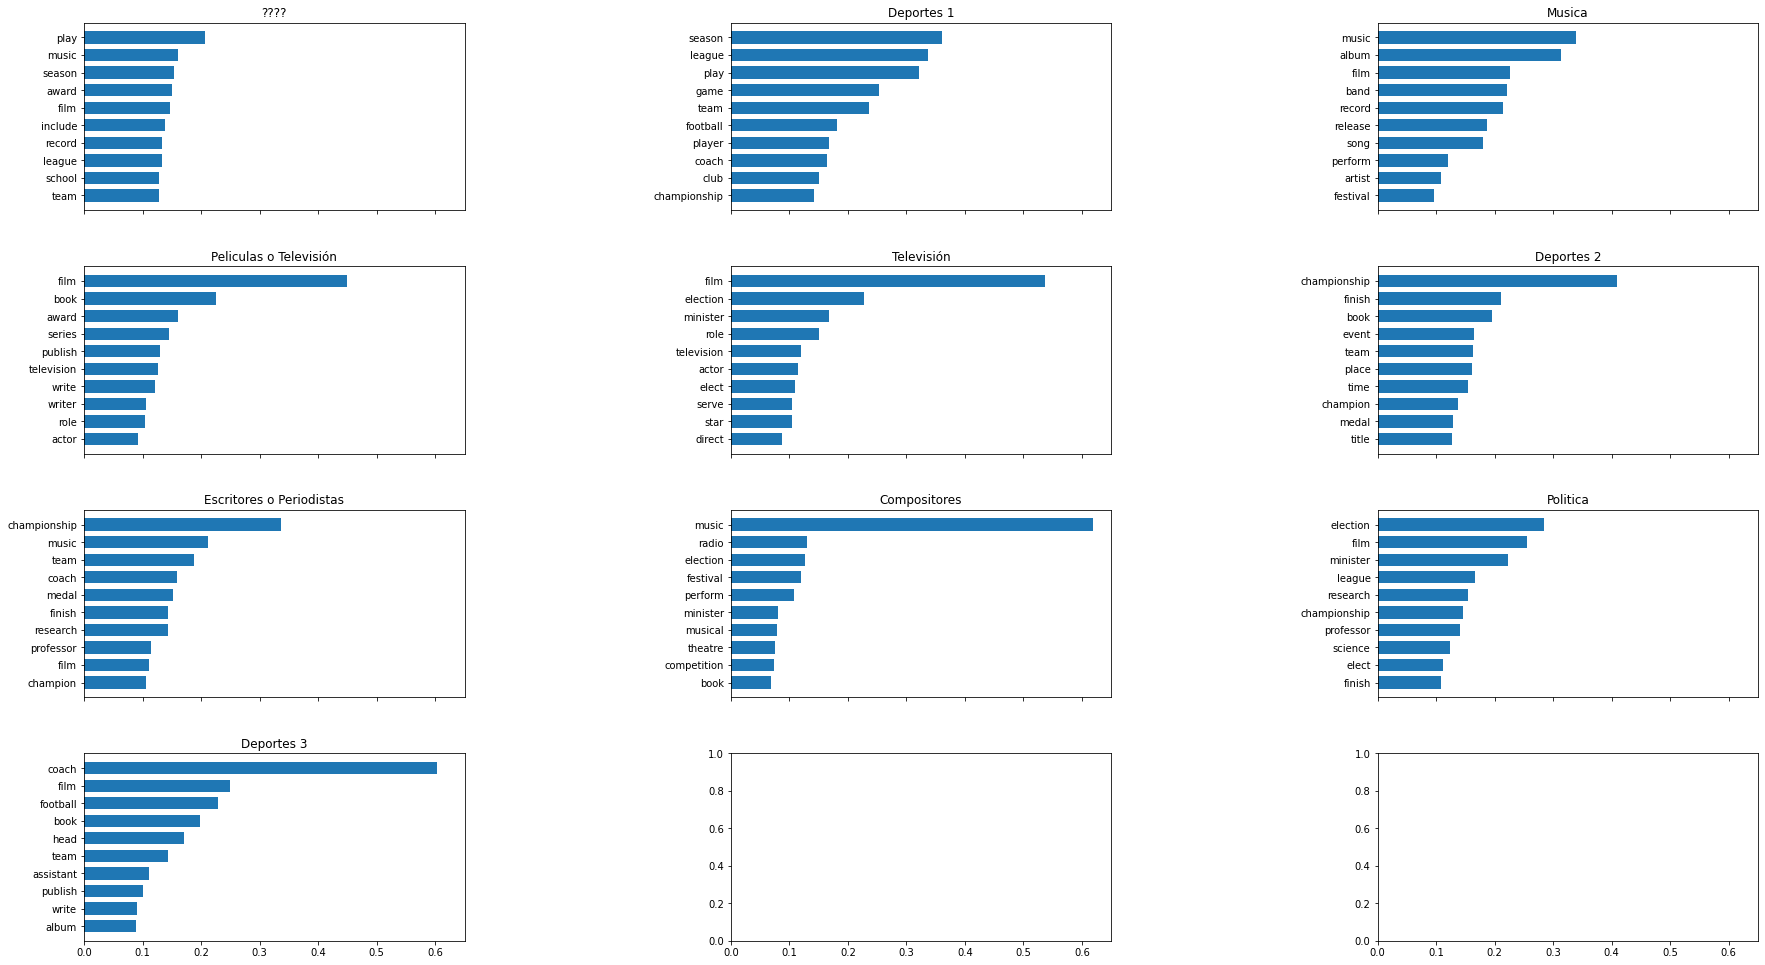

In [ ]:
#Palabras mas importantes del modelo lematizado

#Asignamos el nombre de los topicos de acuerdo a los resultados vistos
topicos = ['????','Deportes 1','Musica','Peliculas o Televisión','Televisión','Deportes 2','Escritores o Periodistas','Compositores','Politica','Deportes 3']

#Mostramos las graficas
print("--- Visualizando tópicos con TruncatedSVD ---")
plot_top_words(fsvd_model, terminos, 10, "TruncatedSVD",topicos)

--- Visualizando tópicos con TruncatedSVD ---


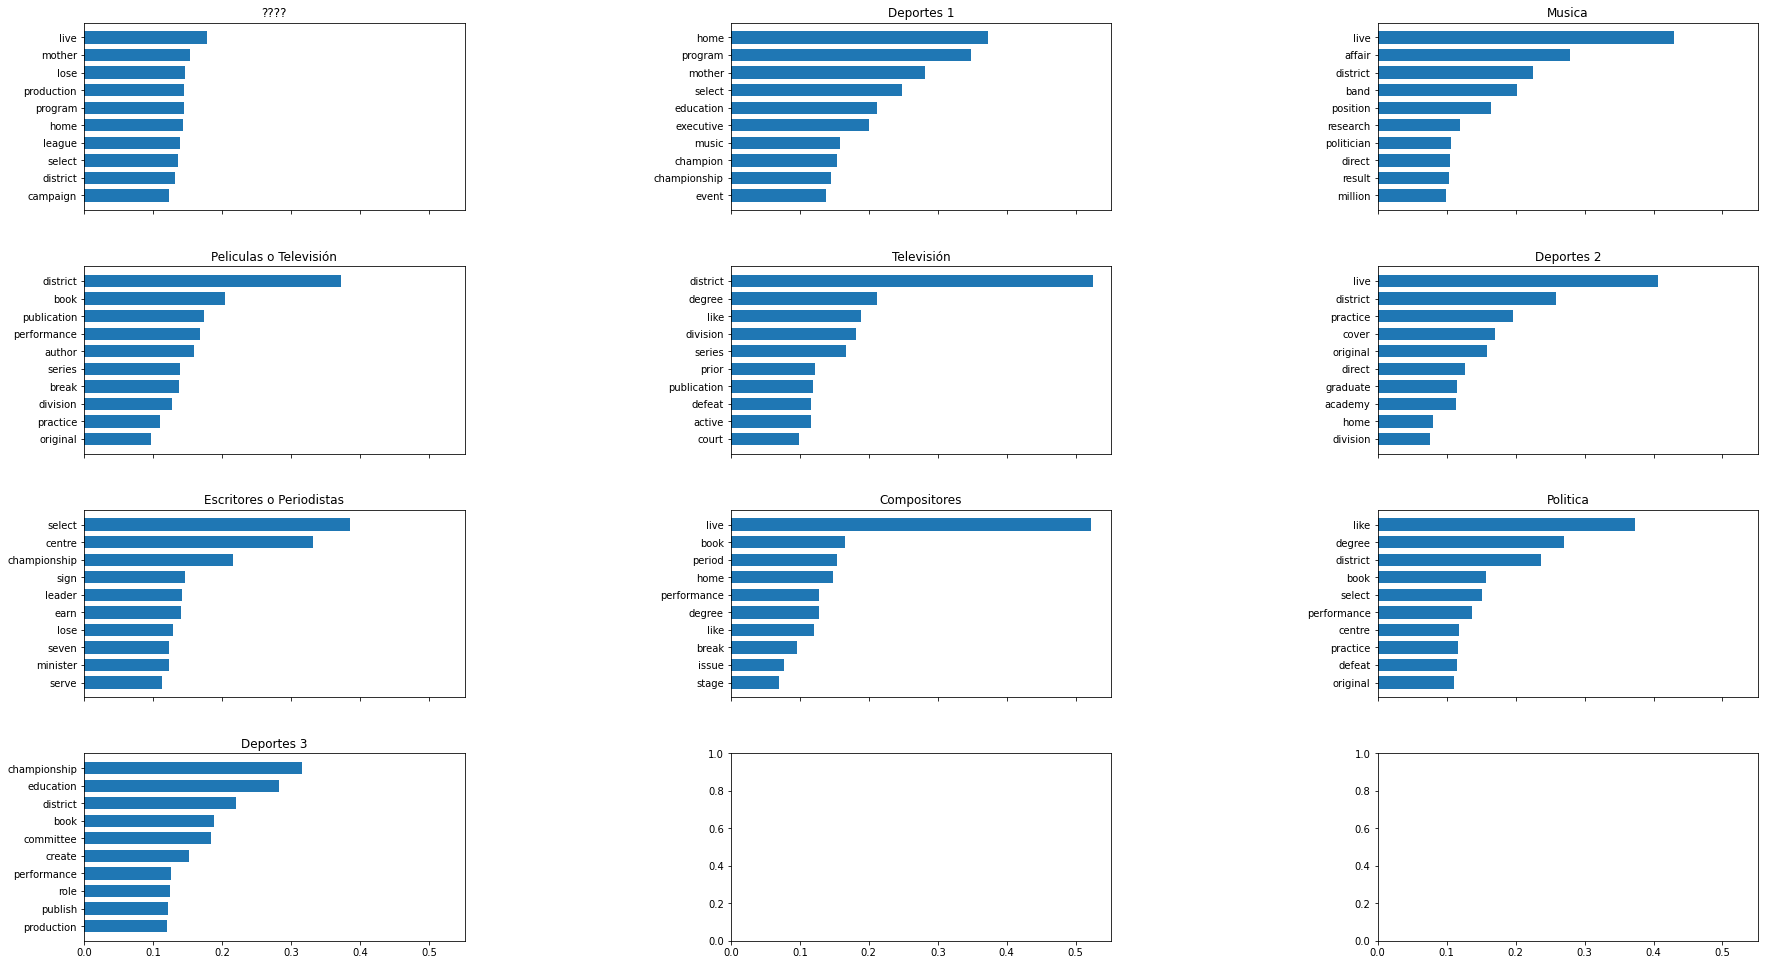

In [ ]:
#Palabras mas importantes del modelo sin lematizar

#Mostramos las graficas
print("--- Visualizando tópicos con TruncatedSVD ---")
plot_top_words(fsvd_model2, terminos, 10, "TruncatedSVD",topicos)

# Clasificación

Una vez identificados los principales tópicos, ahora se desea clasificar a cada documento en alguno de los temas previos. 

Para lo anterior primeramente se necesita una matriz que almacene el peso de las palabras por los temas. Pero, justo esa matriz buscada es $V^T$ de la descomposición SVD. (En la imagen se muestra $V$)

<figure>
<center>
<img src='https://raw.githubusercontent.com/huguito-rangel/mi_primer_repo/master/Imagen1.png' height="300" />
</center>
</figure>

In [ ]:
# Tomamos VT, que tiene los pesos para cada tópico:

from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(X, 
                              n_components=10, #Dimensionalidad deseada de los datos de salida.
                              n_iter=100,
                              random_state=122)
VT.shape

(10, 310)

Después se necesita una matriz que contenga la información de ocurrencia de las palabras en cada documento. Será calculada con `CountVectorizer` del módulo de `sklearn`

<figure>
<center>
<img src='https://raw.githubusercontent.com/huguito-rangel/mi_primer_repo/master/Imagen2.png' height="300" />
</center>
</figure>



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=terminos, min_df=0,
                             token_pattern=r"(?u)\b\w+\b", binary=False)
X = vectorizer.fit_transform(df['text'].values)
result = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
result = result.values
result.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(42786, 310)

El siguiente paso es multiplicar las dos matrices anteriores y obtener como resultado una matriz que indique la importancia de cada documento por tema.

<figure>
<center>
<img src='https://raw.githubusercontent.com/huguito-rangel/mi_primer_repo/master/Imagen4.png' height="180" />
</center>
</figure>

In [ ]:
Matriz_item = result @ VT.T
Matriz_item.shape

(42786, 10)

Finalmente se elige la puntuación más alta y se clasifica en ese grupo.
<figure>
<center>
<img src='https://raw.githubusercontent.com/huguito-rangel/mi_primer_repo/master/Imagen3.png' height="200" />
</center>
</figure>

In [ ]:
df['Class'] = Matriz_item.argmax(axis = 1)

Ahora desplegaremos los resultados que hemos obtenido para 3 clases: Deportes3, Política y Compositores

In [ ]:
# Visualiza los que se clasificaron en Deportes3
df[df['Class'] == 9][['name', 'text']]

,name,text
114,Al Hairston,alan leroy former basketball player college sc...
472,Randy Brown (American football),national league kick coach raven raven super b...
879,John Ellinger,former soccer coach state mens national soccer...
994,Larry Dippel,wellknown former football coach small farm com...
1218,Bo Overton,basketball coach currently coach woman basketb...
...,...,...
42223,Bret Ingalls,current offensive line coach orleans saint coa...
42299,Vitaliy Cherniy,basketball coach former player today coach kyi...
42321,Randy Rahe,college basketball coach current head men bask...
42568,George Graham (rugby),stirling former league union footballer role p...


<figure>
<center>
<img src='https://raw.githubusercontent.com/danielfrgs/2023_1-Datos_Masivos_II/main/Unidad1/Miniproyecto/1.png' height="400" />
</center>
</figure>

In [ ]:
# Visualiza los que se clasificaron en Política
df[df['Class'] == 8][['name', 'text']]

,name,text
234,Dave Chomiak,david walter politician currently cabinet mini...
1608,Bhaskar Jadhav,former minister labour special assistancemahar...
1724,U. C. Raman,politician president union dalit league schedu...
1827,Snyder Rini,solomon island politician briefly eighth prime...
2375,Rosa Elba P%C3%A9rez,prez hernndez septiembreactualmente diputada f...
...,...,...
40469,David Dewhurst,henry lieutenant governor serve member republi...
40536,David Arore,papua politicianhe first elect national parlia...
41059,Arch Pafford,politician brunswick canadain federal election...
42154,C%C3%A9sar Ra%C3%BAl Ojeda Zubieta,csar politician member democratic revolution p...


<figure>
<center>
<img src='https://raw.githubusercontent.com/danielfrgs/2023_1-Datos_Masivos_II/main/Unidad1/Miniproyecto/2.png' height="400" />
</center>
</figure>

In [ ]:
# Visualiza los que se clasificaron en Compositores
df[df['Class'] == 7][['name', 'text']]

,name,text
36,Th%C3%BCring Br%C3%A4m,thring composer conductorbrm graduate school b...
121,Oscar Milani,rosario study medicine music bariloche foundat...
128,Viktoriya Yermolyeva,pianist start classical pianist several piano ...
189,Jeremy Beck,composer know importance embrace past also go ...
214,John Acquaviva,italianborn producer artist musical entreprene...
...,...,...
42424,Albert Patron,america also composer music theorist writer ph...
42479,Jane W. Davidson,musicologist professor creative performing art...
42573,Wally Shoup,jazz alto saxophonist painter base since mains...
42745,M. K. Arjunan,malayalam fondly call master malayalam music c...


<figure>
<center>
<img src='https://raw.githubusercontent.com/danielfrgs/2023_1-Datos_Masivos_II/main/Unidad1/Miniproyecto/3.png' height="400" />
</center>
</figure>